<a href="https://colab.research.google.com/github/durbasmriti/CV_PclubTask/blob/main/Copy_of_try1CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow keras

In [ ]:
import os
import cv2
import numpy as np

from sklearn.model_selection import train_test_split

female_path = '/content/drive/MyDrive/female_wearing_masks/female wearing mask'
male_path = '/content/drive/MyDrive/male_weearing_masks/male wearing mask'

def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, (224, 224))  # Resize images to 224x224
            images.append(img)
            labels.append(label)
    return images, labels


In [ ]:
female_images, female_labels = load_images_from_folder(female_path, 0)
male_images, male_labels = load_images_from_folder(male_path, 1)

images = np.array(female_images + male_images)  # combining
labels = np.array(female_labels + male_labels)  # labelling

images = images / 255.0 # Normalize images in the range [0,1]

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [ ]:
print("Number of images:", len(images))
print("Number of labels:", len(labels))

Number of images: 2281
Number of labels: 2281


I found out that the following code is consuming too much RAM hence commented out :p .

If your system allows then you can run it


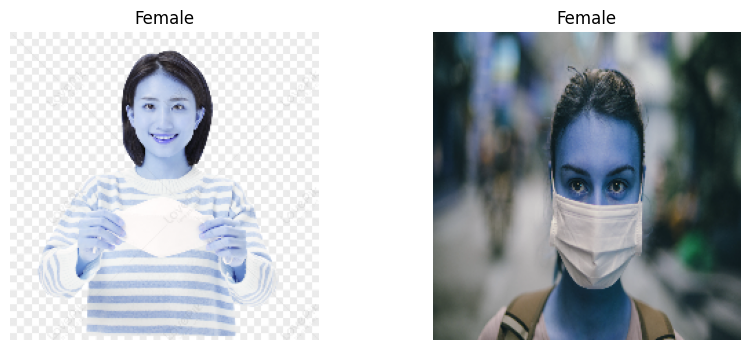

In [ ]:
# import matplotlib.pyplot as plt
# def plot_random_images(images, labels, num_images=2):
#     plt.figure(figsize=(10, 2*num_images))
#     for i in range(num_images):
#         index = np.random.randint(0, len(images))
#         img = images[index]
#         label = 'Female' if labels[index] == 0 else 'Male'
#         plt.subplot(1, num_images, i+1)
#         plt.imshow(img)
#         plt.title(label)
#         plt.axis('off')
#     plt.show()

# plot_random_images(images, labels, num_images=2)   # call the function to plot random images

VGG16-->This imports the VGG16 model, a pre-trained convolutional neural network model

preprocess_input--> This function preprocesses the input data to match the format required by the VGG16 model.

Model: This is used to create a new Keras model.

Dense and Flatten: These are layers used in the custom neural network that will be added on top of the pre-trained VGG16 model.

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Dense, Flatten

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False  # Freeze the layers of the base model

x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()   #to see the architecture and parameters of the model.


58889256/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

monitor='val_loss'> This tells the callback to monitor the validation loss during training.

patience=3 --> This specifies the number of epochs to wait before stopping training if the monitored quantity (validation loss in this case) has not improved.

restore_best_weights=True --> This ensures that the model weights are restored to the best weights observed during training when the early stopping condition is met.

best_model.h5'-> This specifies the filename where the best model weights will be saved.

save_best_only=True-> This ensures that only the weights of the best performing model are saved.

mode='min'> the model with the lowest validation loss will be saved.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')
datagen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


infinite_generator()-> creates an instance of the infinite_generator by passing the output of datagen.flow(x_train, y_train, batch_size=16) as the input generator

datagen.flow(x_train, y_train, batch_size=16)--> generates batches of augmented data (images and corresponding labels) using the data augmentation parameters specified earlier.

In [ ]:
def infinite_generator(generator):
    while True:
        for batch in generator:
            yield batch

train_generator = infinite_generator(datagen.flow(x_train, y_train, batch_size=16))

history = model.fit(train_generator,
                    validation_data=(x_test, y_test),
                    epochs=10,
                    steps_per_epoch=len(x_train)//16,  # Adjust steps_per_epoch accordingly
                    validation_steps=len(x_test)//16,  # Adjust validation_steps accordingly
                    callbacks=[early_stopping, checkpoint])

Epoch 1/10
60/60 [==============================] - ETA: 0s - loss: 0.9792 - accuracy: 0.5427

#  model Evaluation

In [ ]:

loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


15/15 [==============================] - 10s 250ms/step - loss: 0.3301 - accuracy: 0.8609
Test Accuracy: 86.09%


Saving masked_tough_M.jpeg to masked_tough_M.jpeg
1/1 [==============================] - 1s 1s/step
Predicted Gender: Female


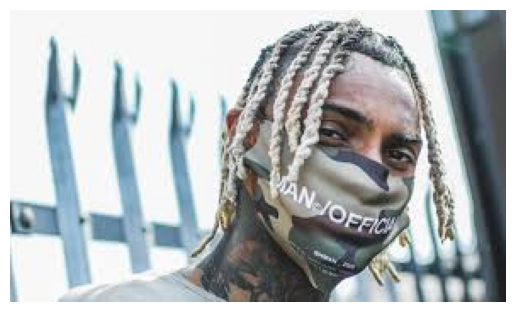

In [ ]:
from google.colab import files
import matplotlib.pyplot as plt

# Function to predict gender
def predict_gender(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img)
    if prediction[0][0] > 0.5:
        print("Predicted Gender is Male")
    else:
        print("Predicted Gender is Female")

uploaded = files.upload()  # Upload an image

# Predict gender for the uploaded image
for image_name in uploaded.keys():
    image_path = image_name
    predict_gender(image_path)

    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
